# Processing Sierra HIVdb Data

In [1]:
'''Imports'''
%pylab inline
import pandas as pd
import json
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Quick wrapper method to make strings easier to work with.
def rm_whitespace(s):
    return ''.join(s.split())

In [13]:
#First, read in the data.
data = pd.concat([pd.read_csv('training_data.csv'),pd.read_csv('test_data.csv')])
data = data.dropna(how='any')

#Log response types and gene types:
response_types = [v for v in data['Resp'].unique() if type(v)==int]
gene_types = [rm_whitespace(c) for c in data.columns if 'Seq' in c]

#Structure the resulting data so we can filter by response types and gene types:
data_map = {0:{},1:{}}

#Iterate through the file tree and get all the json files.
for response_type in response_types:
    for gene_type in gene_types:
        f_name = './files/{}/{}'.format(response_type,gene_type)

        gene_mutations = pd.DataFrame()
        
        counter = 0
        for f in os.listdir(f_name):
            json_data = open('{}/{}/{}_seq.json'.format(f_name,f,f), 'r')
            jdata = json.loads(json_data.read())
            
            #Grab pairwise data from json
            pairwise = jdata[0]['alignedGeneSequences'][0]['prettyPairwise']
            #Get Nucleic Acids:
            nas = pairwise['alignedNAsLine']
            
            #Grab mutations at these locations
            res = pairwise['mutationLine']
            if counter%100==0:
                print(response_type, gene_type, '@{}'.format(f), '|',nas)
                print(res)
            #Encode these mutations to strings.
            vals = [s.encode('ascii') for s in res]
            #Make the pairwise data our index.
            idx = pd.Index([int(p) for p in pairwise['positionLine']])

            #Combine all this into a pd Series, and concat all the series together into a DataFrame.
            mut_series = pd.Series(vals,index=idx,name=int(f))
            gene_mutations=pd.concat([gene_mutations,mut_series],axis=1)
            
            counter += 1
            
        #Pandas Magic: Results in the frequency value counts for each mutation type at every AA position.
        mut_freq_by_position = gene_mutations.transpose().apply(lambda x: x.value_counts(normalize=True)).fillna(0)
        #Store this!
        data_map[response_type][gene_type]=mut_freq_by_position

0 PRSeq @0 | ['CCT', 'CAA', 'ATC', 'ACT', 'CTT', 'TGG', 'CAA', 'CGA', 'CCC', 'CTC', 'GTC', 'CCA', 'ATA', 'AGG', 'ATA', 'GGG', 'GGG', 'CAA', 'CTA', 'AAG', 'GAA', 'GCY', 'CTA', 'TTA', 'GAT', 'ACA', 'GGA', 'GCA', 'GAT', 'GAT', 'ACA', 'GTA', 'TTA', 'GAA', 'GAC', 'ATG', 'GAG', 'TTG', 'CCA', 'GGA', 'AGA', 'TGG', 'AAA', 'CCA', 'AAA', 'ATG', 'ATA', 'GGG', 'GGA', 'ATT', 'GGA', 'GGT', 'TTT', 'ATC', 'AAA', 'GTA', 'ARA', 'CAG', 'TAT', 'GAT', 'CAG', 'RTA', 'CCC', 'ATA', 'GAA', 'ATC', 'TAT', 'GGA', 'CAT', 'AAA', 'GCT', 'GTA', 'GGT', 'ACA', 'GTA', 'TTA', 'ATA', 'GGA', 'CCT', 'ACA', 'CCT', 'GTC', 'AAC', 'ATA', 'ATT', 'GGA', 'AGA', 'AAT', 'CTG', 'TTG', 'ACT', 'CAG', 'CTT', 'GGT', 'TGC', 'ACT', 'TTA', 'AAT', 'TTY']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' P ', ' - ', ' R ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' D ', ' - ', ' E ', ' - ', ' - ', ' - ', ' - ', ' - '

In [14]:
data_map[0]['PRSeq'].head()

,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
b' - ',1.0,0.99723,0.990305,0.995845,0.993094,0.988950,0.991713,0.986188,1.0,0.594483,...,0.73397,0.993179,0.972715,0.568895,1.0,0.983629,1.0,1.0,0.997271,0.998613
b' A ',0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
b' C ',0.0,0.00000,0.000000,0.000000,0.000000,0.001381,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
b' D ',0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
b' E ',0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.002762,0.000000,0.0,0.000000,...,0.00000,0.000000,0.005457,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


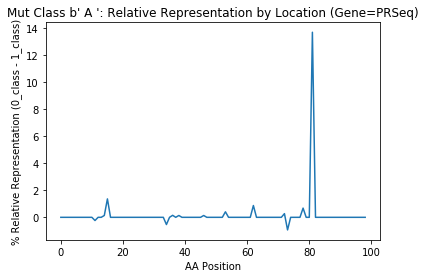

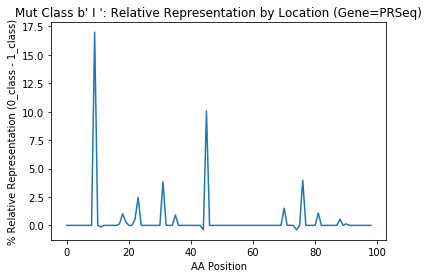

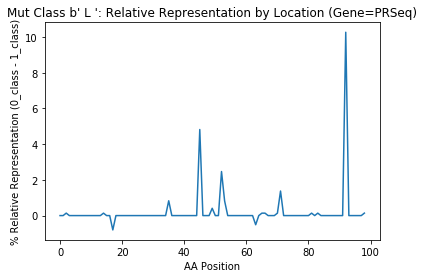

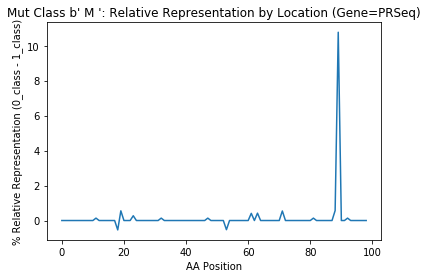

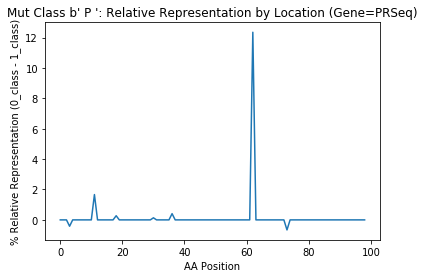

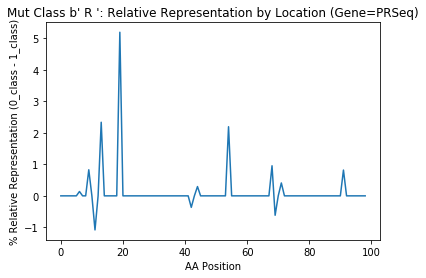

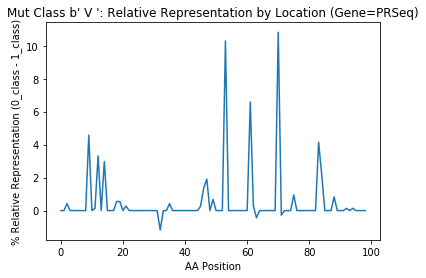

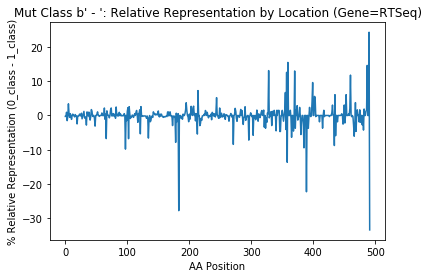

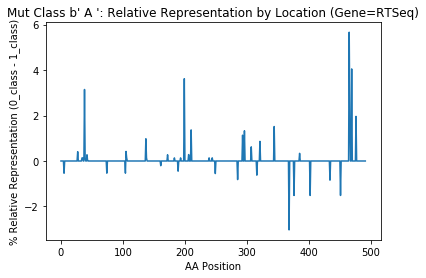

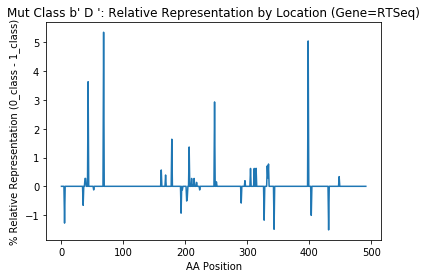

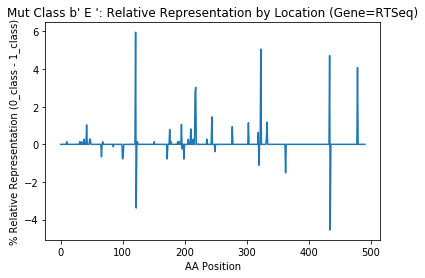

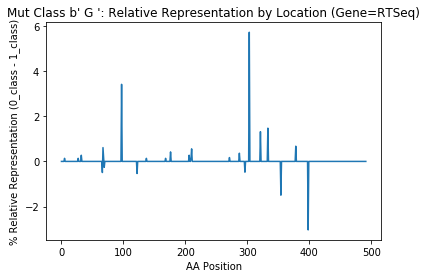

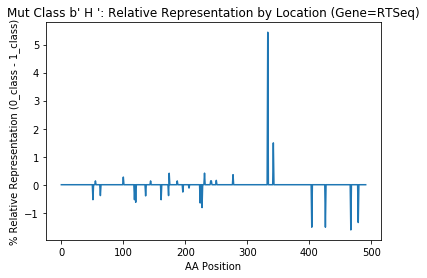

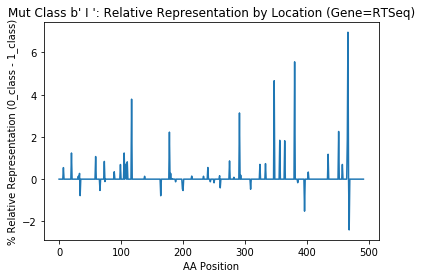

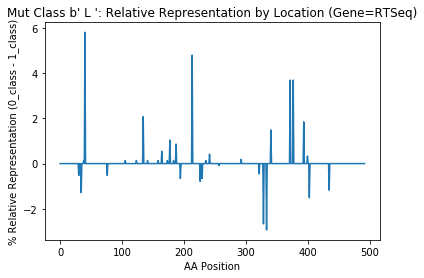

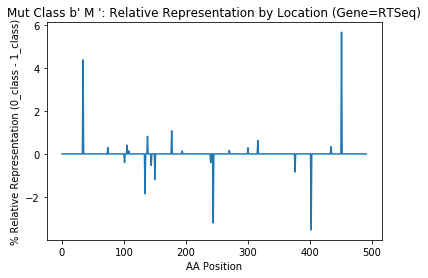

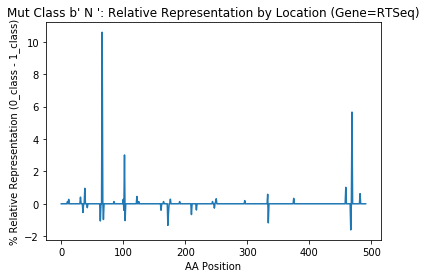

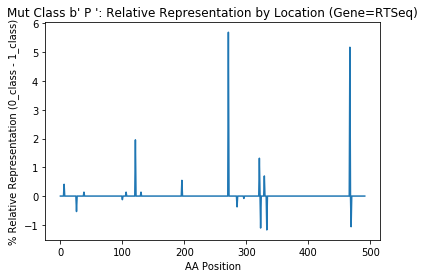

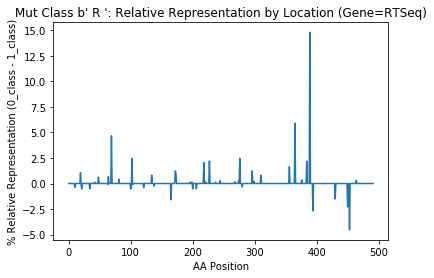

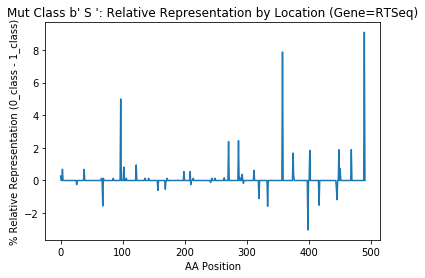

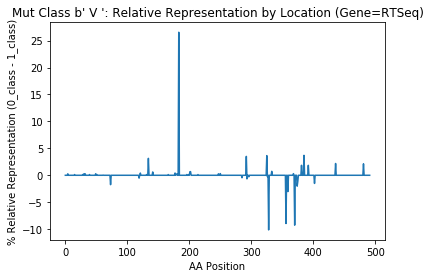

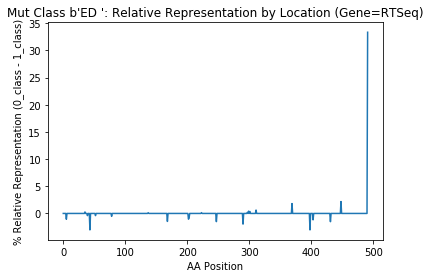

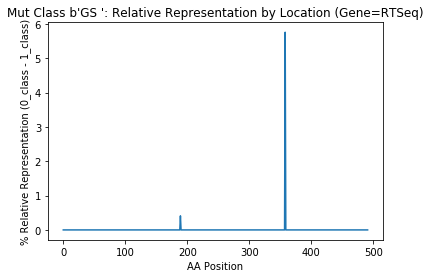

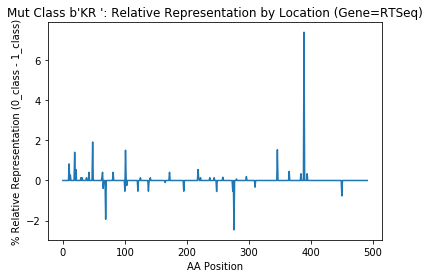

In [7]:
'''
This cell is straightforward: For each gene type, and then for each mutation type, 
compare relative percentage representation by subtracting 1-class frequency from 0-class frequency.
The result is a graph that peaks when a mutation at the X-axis AA position along the protein
is more common in treatment-resistant strains, and troughs when the same is more common in treatment-responding
strains.

I arbitrarily set the  cuttoff proportional representation to 5%. You can make this 0 to graph 
representation for all mutations. The higher the number, the more a mutation has to be exclusive
to one resistance type in order for it to be plotted.

'''

threshold = 5 

for g in gene_types:
    df_0 = data_map[0][g]
    df_1 = data_map[1][g]
    zero_muts = df_0.index
    one_muts = df_1.index
    all_muts = zero_muts.union(one_muts)
    shared_muts = zero_muts.intersection(one_muts)
    #print(len(zero_muts), len(one_muts), len(all_muts), len(shared_muts))
    for mut in shared_muts:
        positional_pairing = list(zip(df_0.loc[mut],df_1.loc[mut]))
        relative_representation = [(x-y)*100 for x,y in positional_pairing]
        if abs(max(relative_representation)) >= threshold:
            plt.plot(relative_representation)
            plt.title('Mut Class {}: Relative Representation by Location (Gene={})'.format(mut.upper(),g))
            plt.ylabel('% Relative Representation (0_class - 1_class)')
            plt.xlabel('AA Position')
            try:
                os.makedirs('graphs/{}/'.format(g))
            except:
                pass
            plt.savefig('graphs/{}/{}_relative_representation.jpg'.format(g,mut.upper()))
            plt.show()


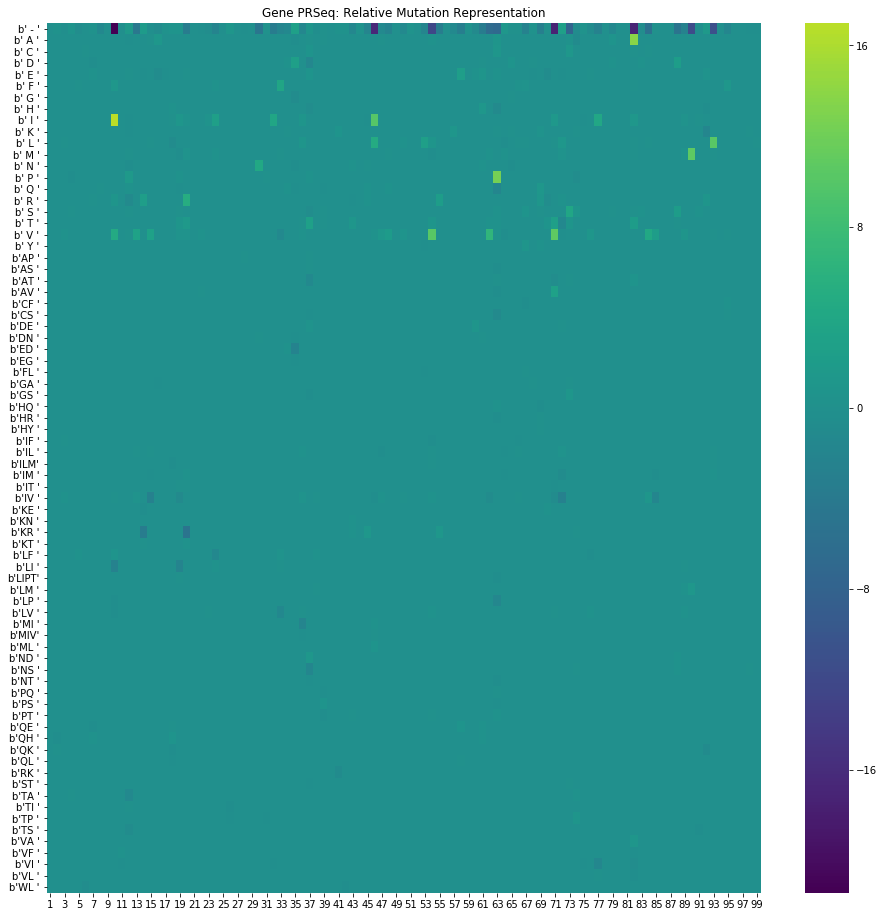

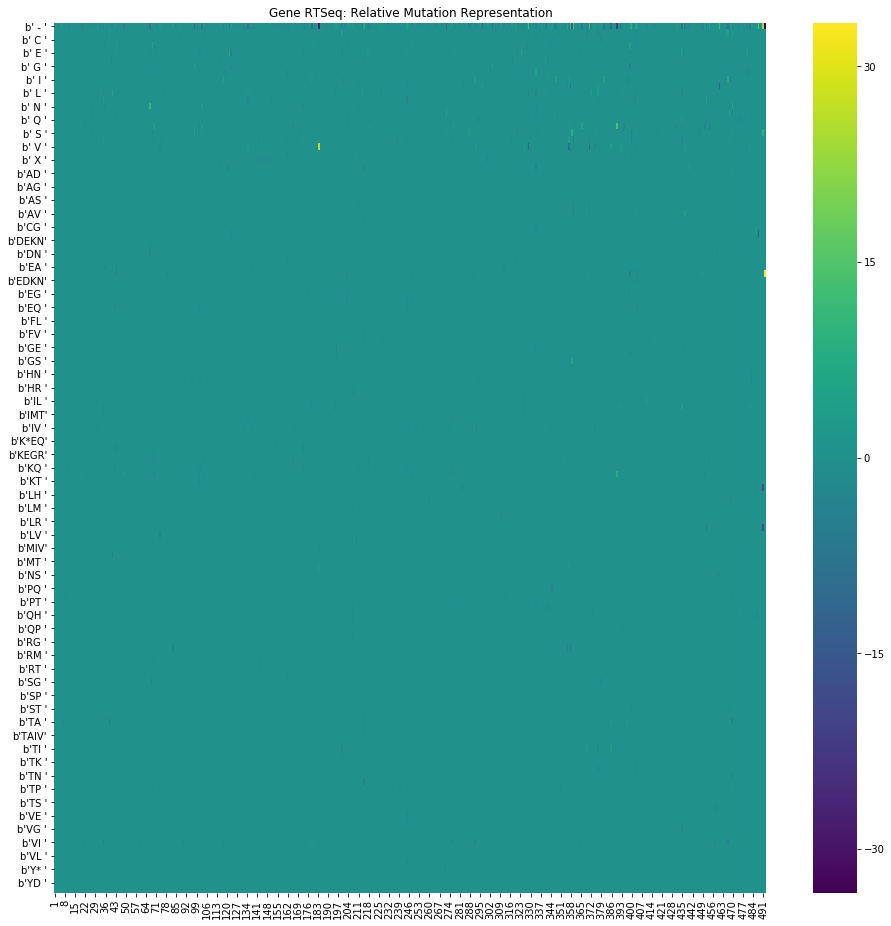

In [8]:
'''

This graphs the same data, but as a heatmap. Mutation types are on the y axis,
AA position is on the X axis, and the legend is in units of decimal frequency (-1 to 1).

'''


import seaborn as sns

orig_cmap = matplotlib.cm.viridis

for g in gene_types:
    df_0 = data_map[0][g]
    df_1 = data_map[1][g]
    zero_muts = df_0.index
    one_muts = df_1.index
    shared_muts = zero_muts.intersection(one_muts)
    df_0_shared = df_0.loc[shared_muts]
    df_1_shared = df_1.loc[shared_muts]
    diff = (df_0_shared-df_1_shared)*100
    diff.to_csv()
    plt.figure(figsize=(16, 16))
    plt.title('Gene {}: Relative Mutation Representation'.format(g))
    plt.ylabel('Mutations (Indexed Alphabetically)')
    plt.xlabel('AA Position')
    sns.heatmap(diff, cmap=orig_cmap, center=0)
    
    try:
        os.makedirs('graphs/{}/'.format(g))
    except:
        pass
    plt.savefig('graphs/{}/{}_heatmap.jpg'.format(g,g))
    diff.to_csv('graphs/{}/{}_heatmap.csv'.format(g,g))
    
    plt.show()